In [ ]:
!python -m spacy download en
!python -m spacy download de
!python -m spacy download es
!python -m spacy download fr

In [1]:
import re
import nltk
import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from nltk.corpus import stopwords

from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from glob import glob

In [26]:
def langcheck(lang):
    if lang == 'en':
        return 'english'
    elif lang == 'es':
        return 'spanish'
    elif lang == 'de':
        return 'german'
    elif lang == 'fr':
        return 'french'
    else:
        raise Exception("Sorry, we don't support this language")

def create_cloud(name, lang):
    tweets = []
    f = pd.read_json('data/qcri/' + name +'_geo.json', lines=True)
    for line in f['text']:
        tweets.append(line)
    
    f = pd.read_csv('data/out/' + name + '.csv', 'rb', delimiter = '\t')
    for line in f['text']:
        tweets.append(line)
    
    nlp = spacy.load(lang)

    stopwordsList = set(nltk.corpus.stopwords.words(langcheck(lang))) # load list of stopwords of target language
    stopwordsList.add('covid') # here we add some covid-related words
    stopwordsList.add('covid19')
    stopwordsList.add('corona')
    stopwordsList.add('coronavirus')
    stopwordsList.add('covid-19')
    stopwordsList.add('-PRON-')

    text = '' # create an empty string

    for row in tweets:
        row = re.sub('((www\.[\s]+)|(https?://[^\s]+))', ' ', row)
        row = re.sub('@[A-Za-z0-9_-]+', ' ', row)
        row = re.sub('RT', ' ', row)
        row = re.sub('#', ' ', row)
        row = re.sub('[^\w\s]', ' ', row)
        row = re.sub('[0-9]', ' ', row)
        text = text + row # collecting preprocessed texts in one string
        
    text = text.lower() # prepare for tokenization
    text_content = nlp(text[:1000000]) # limit of method 1000000
    text_content = [token.lemma_ for token in text_content]
    

    text_content = [word for word in text_content if word not in stopwordsList] # deleting stopwords in text
    text_content = [s for s in text_content if len(s) >= 4] # filter words with lenght smaller than ...

    fdist = nltk.FreqDist(text_content)   
        
    word_dict = {}
    for key in fdist:
        word_dict[key] = fdist[key]  

    wordCloud = WordCloud(stopwords=stopwords, width=1000, height=500, max_font_size=100, 
                            max_words=100, background_color="white")
    wordCloud.generate_from_frequencies(word_dict)
        
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.savefig('phe_uk.png', bbox_inches='tight')
    plt.show()

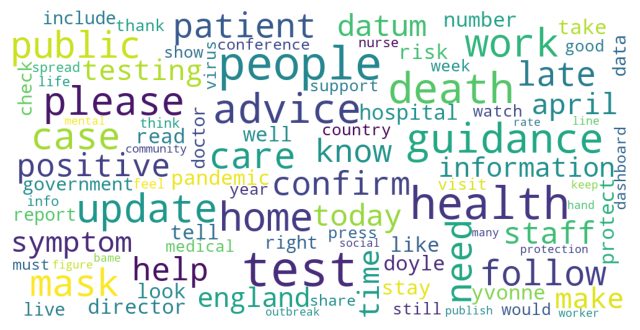

In [29]:
#create_cloud('data/out/gobmx.csv', 'es') # support of 'en', 'es', 'de', 'fr' languages
create_cloud('phe_uk', 'en')